In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [5]:
# Fetching the dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:07<00:00, 1300162.83it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 236910.11it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:07<00:00, 209704.64it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1629225.07it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
class HISVAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=2):
        super(HISVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim*2)  # Outputs mu and log_var
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x.view(-1, 784))
        mu, log_var = h.chunk(2, dim=-1)
        mu = torch.clamp(mu, min=-10, max=10)
        log_var = torch.clamp(log_var, min=-10, max=10)
        return mu, log_var

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        gen = self.decode(z)
        return gen, mu, log_var, z

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def hamiltonian(self, z, p, mu, log_var):
        kinetic = torch.sum(p**2, dim=1) / 2
        potential = torch.sum(0.5 * ((z - mu) / torch.exp(0.5 * log_var))**2, dim=1)
        return kinetic + potential

    def leapfrog_adaptive(self, z, p, mu, log_var, step_size, K, beta0):
        z, p = z.clone(), p.clone()
        for k in range(1, K+1):
            # Start of leapfrog step
            p -= step_size / 2 * self.grad_potential(z, mu, log_var)
            z += step_size * p
            p -= step_size / 2 * self.grad_potential(z, mu, log_var)
            
            # Adaptive tempering
            beta_k = (1 - (1 / beta0)**0.5) * (k**2 / K**2) + (1 / beta0)**0.5
            p *= (beta0 / beta_k)**0.5
        
        return z, p, beta_k

    def grad_potential(self, z, mu, log_var):
        return (z - mu) / torch.exp(log_var)

def hva_his_loss_adaptive(reconstructed_x, x, mu, log_var, z, p, model, step_size, K, beta0):
    # Standard VAE reconstruction loss
    reconstructed_x = reconstructed_x.clamp(0, 1)
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')

    # Calculate the Hamiltonian for initial state
    initial_hamiltonian = model.hamiltonian(z, p, mu, log_var)
    
    # Perform adaptive leapfrog steps
    z_new, p_new, beta_k = model.leapfrog_adaptive(z, p, mu, log_var, step_size, K, beta0)
    
    # Calculate the Hamiltonian for the evolved state
    final_hamiltonian = model.hamiltonian(z_new, p_new, mu, log_var)
    
    # Calculate log importance weights
    log_posterior = -final_hamiltonian
    log_prior = -initial_hamiltonian
    log_weights = log_posterior - log_prior
    
    # Log mean of weights for stability
    log_mean_weights = torch.logsumexp(log_weights, dim=0) - torch.log(torch.tensor(len(log_weights), dtype=torch.float32))
    
    # Calculate weighted reconstruction loss
    weighted_BCE = log_mean_weights.exp() * BCE
    
    return torch.mean(weighted_BCE)

hisvae = HISVAE()
optimizer = optim.Adam(hisvae.parameters(), lr=0.001)

def trainHISVAE_adaptive(model, optimizer, train_loader, val_loader, step_size=0.001, K=10, beta0=1.0):
    model.train()
    best_val_loss = float('inf')
    epochs_no_improve = 0
    max_epochs = 1000
    epoch = 0
    patience = 10  # Number of epochs to wait for improvement before stopping the training

    while epoch < max_epochs and epochs_no_improve < patience:
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(next(model.parameters()).device)
            optimizer.zero_grad()
            recon_batch, mu, log_var, z = model(data)
            p = torch.randn_like(z)  # Sample initial momenta for HIS
            loss = hva_his_loss_adaptive(recon_batch, data, mu, log_var, z, p, model, step_size, K, beta0)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f'Train Epoch: {epoch + 1} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(next(model.parameters()).device)
                recon_batch, mu, log_var, z = model(data)
                p = torch.randn_like(z)
                loss = hva_his_loss_adaptive(recon_batch, data, mu, log_var, z, p, model, step_size, K, beta0)
                val_loss += loss.item()

        val_loss /= len(val_loader.dataset)
        print(f'====> Epoch: {epoch + 1} Validation loss: {val_loss:.4f}')

        # Check if validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f'No improvement in validation loss for {epochs_no_improve} epoch(s)')

        # Check for early stopping
        if epochs_no_improve >= patience:
            print("Early stopping triggered due to no improvement in validation loss.")
            break

        epoch += 1

trainHISVAE_adaptive(hisvae, optimizer, train_loader, test_loader)


Train Epoch: 1 [0/60000 (0%)]	Loss: 550.032349
Train Epoch: 1 [6400/60000 (11%)]	Loss: 171.695633
Train Epoch: 1 [12800/60000 (21%)]	Loss: 179.774780
Train Epoch: 1 [19200/60000 (32%)]	Loss: 164.841003
Train Epoch: 1 [25600/60000 (43%)]	Loss: 172.313904
Train Epoch: 1 [32000/60000 (53%)]	Loss: 152.105408
Train Epoch: 1 [38400/60000 (64%)]	Loss: 162.329025
Train Epoch: 1 [44800/60000 (75%)]	Loss: 162.592575
Train Epoch: 1 [51200/60000 (85%)]	Loss: 151.685898
Train Epoch: 1 [57600/60000 (96%)]	Loss: 157.905029
====> Epoch: 1 Validation loss: 160.4364
Train Epoch: 2 [0/60000 (0%)]	Loss: 163.030029
Train Epoch: 2 [6400/60000 (11%)]	Loss: 165.124237
Train Epoch: 2 [12800/60000 (21%)]	Loss: 159.453064
Train Epoch: 2 [19200/60000 (32%)]	Loss: 154.179886
Train Epoch: 2 [25600/60000 (43%)]	Loss: 149.550018
Train Epoch: 2 [32000/60000 (53%)]	Loss: 151.374146
Train Epoch: 2 [38400/60000 (64%)]	Loss: 157.939651
Train Epoch: 2 [44800/60000 (75%)]	Loss: 151.963242
Train Epoch: 2 [51200/60000 (85%)]	

In [14]:
import numpy as np
import pandas as pd

from scipy.stats import mode, norm

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import seaborn as sns

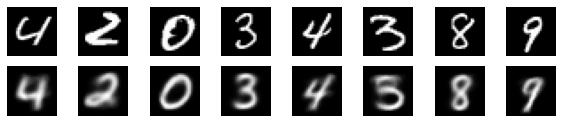

In [11]:
hisvae.to(device)
def visualize_reconstruction(model, data):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        recon, _, _, _ = model(data)
        data = data.cpu()
        recon = recon.cpu()
        num_images = 8
        fig, axs = plt.subplots(2, num_images, figsize=(10, 2))
        for i in range(num_images):
            axs[0, i].imshow(data[i].reshape(28, 28), cmap='gray')
            axs[0, i].axis('off')
            axs[1, i].imshow(recon[i].reshape(28, 28), cmap='gray')
            axs[1, i].axis('off')
        plt.show()

data, _ = next(iter(train_loader))
visualize_reconstruction(hisvae, data)

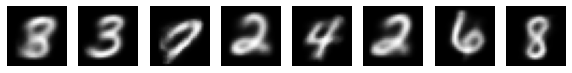

In [12]:
def visualize_random_samples(model):
    with torch.no_grad():
        z = torch.randn(8, 2).to(device)
        samples = model.decoder(z).cpu()
        plt.figure(figsize=(10, 2))
        for i in range(8):
            plt.subplot(1, 8, i + 1)
            plt.imshow(samples[i].reshape(28, 28), cmap='gray')
            plt.axis('off')
        plt.show()

visualize_random_samples(hisvae)

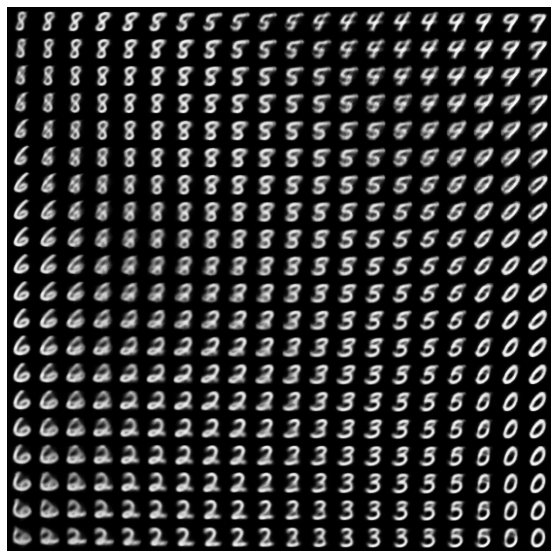

In [15]:
hisvae.eval()  # Set the model to evaluation mode

# Visualization parameters
samples_per_dim = 20
digit_size = 28

# Prepare the grid of latent variables
grid_x = norm.ppf(np.linspace(0.05, 0.95, samples_per_dim))
grid_y = norm.ppf(np.linspace(0.05, 0.95, samples_per_dim))

figure = np.zeros((digit_size * samples_per_dim,
                   digit_size * samples_per_dim))

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        # Transform the grid points to tensor and decode
        z_sample = torch.tensor([[xi, yi]], dtype=torch.float32)
        z_sample = z_sample.to(next(hisvae.parameters()).device)  # Ensure the sample is on the correct device
        x_decoded = hisvae.decoder(z_sample)
        x_decoded = x_decoded.cpu().detach().numpy()  # Convert back to numpy from tensor
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[j * digit_size: (j + 1) * digit_size,
               i * digit_size: (i + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')  # Hide axes to focus only on the generated digits
plt.show()

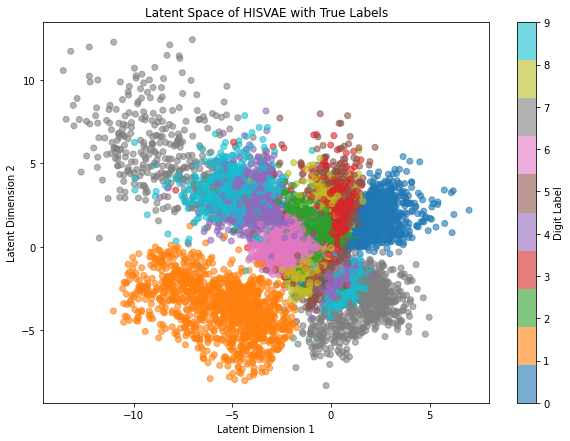

In [16]:
def extract_latent_variables_and_labels(loader, model):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for batch, label in loader:
            batch = batch.to(next(model.parameters()).device)  # Move data to device
            output = model.encoder(batch.view(-1, 784))  # Process batch
            mu = output[0] if isinstance(output, tuple) else output  # Extract mu, checking output type
            latents.append(mu.cpu().numpy())  # Convert mu to numpy and store
            labels.append(label.cpu().numpy())  # Store labels
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels)
    return latents, labels

latent_variables, true_labels = extract_latent_variables_and_labels(test_loader, hisvae)


plt.figure(figsize=(10, 7))
scatter = plt.scatter(latent_variables[:, 0], latent_variables[:, 1], c=true_labels, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Digit Label', ticks=range(10))
plt.title('Latent Space of HISVAE with True Labels')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
import numpy as np


class VAE(nn.Module):
    def __init__(self, args, avg_logit):
        super(VAE, self).__init__()
        self.z_dim = args.z_dim
        self.avg_logit = avg_logit
        self._set_net_params()

    def get_elbo(self, x, args):
        q_mu, q_sigma = self._inf_network(x)
        q_z = dist.Normal(q_mu, q_sigma)

        z = q_z.rsample()
        p_x_given_z_logits = self._gen_network(z)
        p_z = dist.Normal(torch.zeros_like(z), torch.ones_like(z))

        kl = dist.kl_divergence(q_z, p_z).sum(1)
        expected_log_likelihood = self._bernoulli_log_likelihood(x, p_x_given_z_logits)
        elbo = (expected_log_likelihood - kl).mean()

        return elbo

    def get_nll(self, x, args):
        q_mu, q_sigma = self._inf_network(x)
        q_z = dist.Normal(q_mu, q_sigma)

        z = q_z.rsample()
        p_x_given_z_logits = self._gen_network(z)
        expected_log_likelihood = self._bernoulli_log_likelihood(x, p_x_given_z_logits)

        prior_minus_gen = (-0.5 * (z ** 2).sum(1)
                           + q_sigma.log().sum(1)
                           + 0.5 * (((z - q_mu) / q_sigma) ** 2).sum(1))
        nll_samples = expected_log_likelihood + prior_minus_gen

        nll_samples_reshaped = nll_samples.view(args.n_IS, args.n_batch_test)
        nll_lse = torch.logsumexp(nll_samples_reshaped, dim=0)
        nll = np.log(args.n_IS) - nll_lse.mean()

        return nll

    def get_samples(self, args):
        z_0 = torch.randn(args.n_gen_samples, self.z_dim, device=self.fc_mu.weight.device)
        logits = self._gen_network(z_0)
        samples = torch.sigmoid(logits)
        return samples

    def _set_net_params(self):
        # Inference network
        self.conv1 = nn.Conv2d(1, 16, 5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(32, 32, 5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 450)
        self.fc_mu = nn.Linear(450, self.z_dim)
        self.fc_sigma = nn.Linear(450, self.z_dim)

        # Generative network
        self.fc_g1 = nn.Linear(self.z_dim, 450)
        self.fc_g2 = nn.Linear(450, 32 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(32, 32, 5, stride=1, padding=2)
        self.deconv2 = nn.ConvTranspose2d(32, 16, 5, stride=2, padding=2, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 1, 5, stride=2, padding=2, output_padding=1)

    def _inf_network(self, x):
        h1 = F.softplus(self.conv1(x))
        h2 = F.softplus(self.conv2(h1))
        h3 = F.softplus(self.conv3(h2))
        h3_flat = h3.view(h3.size(0), -1)
        h4 = F.softplus(self.fc1(h3_flat))
        mu = self.fc_mu(h4)
        sigma = F.softplus(self.fc_sigma(h4))
        return mu, sigma

    def _gen_network(self, z):
        h1 = F.softplus(self.fc_g1(z))
        h2 = F.softplus(self.fc_g2(h1))
        h2_2d = h2.view(h2.size(0), 32, 7, 7)
        h3 = F.softplus(self.deconv1(h2_2d))
        h4 = F.softplus(self.deconv2(h3))
        logits = self.deconv3(h4)
        return logits

    def _bernoulli_log_likelihood(self, x, logits):
        return -F.binary_cross_entropy_with_logits(logits, x, reduction='none').sum([1, 2, 3])


class HVAE(VAE):
    def __init__(self, args, avg_logit):
        super().__init__(args, avg_logit)
        self.K = args.K
        self.args = args  # Store args for later use
        self._init_hvae_params()

    def _init_hvae_params(self):
        init_lf = self.args.init_lf * np.ones(self.z_dim)
        init_lf_reparam = np.log(init_lf / (self.args.max_lf - init_lf))

        if self.args.vary_eps == 'true':
            init_lf_reparam = np.tile(init_lf_reparam, (self.K, 1))

        self.lf_reparam = nn.Parameter(torch.tensor(init_lf_reparam, dtype=torch.float32))
        self.temp_method = self.args.temp_method

        if self.temp_method == 'free':
            init_alphas = self.args.init_alpha * np.ones(self.K)
            init_alphas_reparam = np.log(init_alphas / (1 - init_alphas))
            self.alphas_reparam = nn.Parameter(torch.tensor(init_alphas_reparam, dtype=torch.float32))
        elif self.temp_method == 'fixed':
            init_T_0 = self.args.init_T_0
            init_T_0_reparam = np.log(init_T_0 - 1)
            self.T_0_reparam = nn.Parameter(torch.tensor(init_T_0_reparam, dtype=torch.float32))
        elif self.temp_method == 'none':
            self.register_buffer('T_0', torch.tensor(1., dtype=torch.float32))
            self.register_buffer('alphas', torch.ones(self.K, dtype=torch.float32))
        else:
            raise ValueError(f'Tempering method {self.temp_method} not supported')

    def get_elbo(self, x, args):
        q_mu, q_sigma = self._inf_network(x)

        z_0 = q_mu + q_sigma * torch.randn_like(q_mu)
        p_0 = torch.sqrt(self.T_0) * torch.randn_like(q_mu)

        z_K, p_K = self._his(z_0, p_0, x, args)

        p_x_given_zK_logits = self._gen_network(z_K)
        expected_log_likelihood = self._bernoulli_log_likelihood(x, p_x_given_zK_logits)

        log_prob_zK = -0.5 * (z_K ** 2).sum(1)
        log_prob_pK = -0.5 * (p_K ** 2).sum(1)
        sum_log_sigma = q_sigma.log().sum(1)

        neg_kl_term = log_prob_zK + log_prob_pK + sum_log_sigma + self.z_dim
        elbo = (expected_log_likelihood + neg_kl_term).mean()

        return elbo

    def get_nll(self, x, args):
        q_mu, q_sigma = self._inf_network(x)

        z_0 = q_mu + q_sigma * torch.randn_like(q_mu)
        p_0 = torch.sqrt(self.T_0) * torch.randn_like(q_mu)

        z_K, p_K = self._his(z_0, p_0, x, args)

        p_x_given_zK_logits = self._gen_network(z_K)
        expected_log_likelihood = self._bernoulli_log_likelihood(x, p_x_given_zK_logits)

        log_prob_zK = -0.5 * (z_K ** 2).sum(1)
        log_prob_pK = -0.5 * (p_K ** 2).sum(1)
        sum_log_sigma = q_sigma.log().sum(1)

        log_prob_z0 = -0.5 * (((z_0 - q_mu) / q_sigma) ** 2).sum(1)
        log_prob_p0 = -0.5 / self.T_0 * (p_0 ** 2).sum(1)

        nll_samples = (expected_log_likelihood + log_prob_zK + log_prob_pK
                       + sum_log_sigma - log_prob_z0 - log_prob_p0)

        nll_samples_reshaped = nll_samples.view(args.n_IS, args.n_batch_test)
        nll_lse = torch.logsumexp(nll_samples_reshaped, dim=0)
        nll = np.log(args.n_IS) - nll_lse.mean()

        return nll

    def _his(self, z_0, p_0, x, args):
        z = z_0
        p = p_0

        for k in range(1, self.K + 1):
            if args.vary_eps == 'true':
                lf_eps = self.lf_eps[k - 1, :]
            else:
                lf_eps = self.lf_eps

            p_half = p - 0.5 * lf_eps * self._dU_dz(z, x)
            z = z + lf_eps * p_half
            p_temp = p_half - 0.5 * lf_eps * self._dU_dz(z, x)

            p = self.alphas[k - 1] * p_temp

        return z, p

    def _dU_dz(self, z, x):
        z.requires_grad_(True)
        net_out = self._gen_network(z)
        U = F.softplus(net_out).sum((1, 2, 3)) - (x * net_out).sum((1, 2, 3))
        grad_U = torch.autograd.grad(U.sum(), z)[0] + z
        return grad_U

    @property
    def lf_eps(self):
        return torch.sigmoid(self.lf_reparam) * self.args.max_lf

    @property
    def alphas(self):
        if self.temp_method == 'free':
            return torch.sigmoid(self.alphas_reparam)
        elif self.temp_method == 'fixed':
            T_0 = 1 + torch.exp(self.T_0_reparam)
            k_vec = torch.arange(1, self.K + 1, dtype=torch.float32, device=self.lf_reparam.device)
            k_m_1_vec = torch.arange(0, self.K, dtype=torch.float32, device=self.lf_reparam.device)
            temp_sched = (1 - T_0) * k_vec ** 2 / self.K ** 2 + T_0
            temp_sched_m_1 = (1 - T_0) * k_m_1_vec ** 2 / self.K ** 2 + T_0
            return torch.sqrt(temp_sched / temp_sched_m_1)
        else:
            return self.alphas

    @property
    def T_0(self):
        if self.temp_method == 'free':
            return torch.prod(self.alphas) ** (-2)
        elif self.temp_method == 'fixed':
            return 1 + torch.exp(self.T_0_reparam)
        else:
            return self.T_0

In [21]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# from vae import VAE  # Assuming the VAE class is in a file named vae.py
# Hyperparameters and settings
BATCH_SIZE = 128
EPOCHS = 2000
LEARNING_RATE = 1e-3
#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Model setup
class Args:
    def __init__(self):
        self.z_dim = 20
        self.n_IS = 1  # For NLL calculation
        self.n_batch_test = BATCH_SIZE
        self.n_gen_samples = 16  # For generating samples
        self.K = 5  # Number of leapfrog steps
        self.init_lf = 0.01  # Initial leapfrog step size
        self.max_lf = 0.1  # Maximum leapfrog step size
        self.vary_eps = 'false'  # Whether to vary epsilon across layers
        self.temp_method = 'free'  # Tempering method: 'free', 'fixed', or 'none'
        self.init_alpha = 0.9  # Initial alpha for free tempering
        self.init_T_0 = 2.0  # Initial temperature for fixed tempering


args = Args()
avg_logit = 0.0  # You may want to calculate this based on your data
model = HVAE(args, avg_logit).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


# Training loop
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        optimizer.zero_grad()
        try:
            elbo = model.get_elbo(data, args)
            loss = -elbo  # Negative ELBO is the loss we want to minimize
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        except Exception as e:
            print(f"Error in batch {batch_idx}: {str(e)}")
            print(f"Input shape: {data.shape}")
            print(f"Input min: {data.min()}, max: {data.max()}")
            raise

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader):.4f}')


# Visualization function
def visualize_reconstructions(epoch):
    model.eval()
    with torch.no_grad():
        sample = next(iter(train_loader))[0][:8].to(DEVICE)
        recon = model._gen_network(model._inf_network(sample)[0])
        recon = torch.sigmoid(recon)

        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        for i in range(8):
            axes[0, i].imshow(sample[i].cpu().squeeze(), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].imshow(recon[i].cpu().squeeze(), cmap='gray')
            axes[1, i].axis('off')
        plt.tight_layout()
        plt.savefig(f'reconstruction_epoch_{epoch}.png')
        plt.close()


# Main training loop
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    if epoch % 10 == 0:
        visualize_reconstructions(epoch)

# Generate samples after training
model.eval()
with torch.no_grad():
    sample = model.get_samples(args)
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(16):
        ax = axes[i // 4, i % 4]
        ax.imshow(sample[i].cpu().squeeze(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('generated_samples.png')
    plt.close()

print("Training complete. Reconstructions and generated samples have been saved.")

Using device: cpu
Train Epoch: 1 [0/60000 (0%)]	Loss: 684.720764
Train Epoch: 1 [12800/60000 (21%)]	Loss: 200.128693
Train Epoch: 1 [25600/60000 (43%)]	Loss: 206.643524
Train Epoch: 1 [38400/60000 (64%)]	Loss: 203.579773
Train Epoch: 1 [51200/60000 (85%)]	Loss: 204.685303
====> Epoch: 1 Average loss: 217.0564
Train Epoch: 2 [0/60000 (0%)]	Loss: 199.531296


KeyboardInterrupt: 

In [24]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# from vae import VAE  # Assuming the VAE class is in a file named vae.py
# Hyperparameters and settings
BATCH_SIZE = 128
EPOCHS = 2000
LEARNING_RATE = 1e-3
#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Model setup
class Args:
    def __init__(self):
        self.z_dim = 20
        self.n_IS = 1  # For NLL calculation
        self.n_batch_test = BATCH_SIZE
        self.n_gen_samples = 16  # For generating samples
        self.K = 5  # Number of leapfrog steps
        self.init_lf = 0.01  # Initial leapfrog step size
        self.max_lf = 0.1  # Maximum leapfrog step size
        self.vary_eps = 'false'  # Whether to vary epsilon across layers
        self.temp_method = 'free'  # Tempering method: 'free', 'fixed', or 'none'
        self.init_alpha = 0.9  # Initial alpha for free tempering
        self.init_T_0 = 2.0  # Initial temperature for fixed tempering


args = Args()
avg_logit = 0.0  # You may want to calculate this based on your data
model = HVAE(args, avg_logit).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        optimizer.zero_grad()
        try:
            elbo = model.get_elbo(data, args)
            loss = -elbo  # Negative ELBO is the loss we want to minimize
            
            # Check for NaNs in the loss
            if torch.isnan(loss).any():
                print(f"NaN detected in loss at epoch {epoch}, batch {batch_idx}. Stopping training.")
                break
            
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        except Exception as e:
            print(f"Error in batch {batch_idx}: {str(e)}")
            print(f"Input shape: {data.shape}")
            print(f"Input min: {data.min()}, max: {data.max()}")
            raise

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader):.4f}')



# Visualization function
def visualize_reconstructions(epoch):
    model.eval()
    with torch.no_grad():
        sample = next(iter(train_loader))[0][:8].to(DEVICE)
        recon = model._gen_network(model._inf_network(sample)[0])
        recon = torch.sigmoid(recon)

        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        for i in range(8):
            axes[0, i].imshow(sample[i].cpu().squeeze(), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].imshow(recon[i].cpu().squeeze(), cmap='gray')
            axes[1, i].axis('off')
        plt.tight_layout()
        plt.savefig(f'reconstruction_epoch_{epoch}.png')
        plt.close()


# Main training loop
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    if epoch % 10 == 0:
        visualize_reconstructions(epoch)

# Generate samples after training
model.eval()
with torch.no_grad():
    sample = model.get_samples(args)
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(16):
        ax = axes[i // 4, i % 4]
        ax.imshow(sample[i].cpu().squeeze(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('generated_samples.png')
    plt.close()

print("Training complete. Reconstructions and generated samples have been saved.")

Using device: cpu
Train Epoch: 1 [0/60000 (0%)]	Loss: 429.791138
Train Epoch: 1 [12800/60000 (21%)]	Loss: 202.114456
Train Epoch: 1 [25600/60000 (43%)]	Loss: 209.552032
Train Epoch: 1 [38400/60000 (64%)]	Loss: 208.041992
Train Epoch: 1 [51200/60000 (85%)]	Loss: 203.368622
====> Epoch: 1 Average loss: 211.1432
Train Epoch: 2 [0/60000 (0%)]	Loss: 211.425568
Train Epoch: 2 [12800/60000 (21%)]	Loss: 199.578705
Train Epoch: 2 [25600/60000 (43%)]	Loss: 184.283783


KeyboardInterrupt: 